<h4 style="background-color:#e15b64;color:white;border-radius: 8px; padding:12px">Functions we'll need</h4>

In [105]:
def pred_test(data):
    for image , label in data.take(1):
        
            
            img = tf.image.resize(image, [224, 224])

            pred = load_model.predict(tf.expand_dims(img,axis=0))
        
    
            plt.figure(figsize=(17,8))
            plt.axis("off")
            plt.title(f" predict : {class_names[pred.argmax()]} actual : {class_names[label]} prob: {pred.max()}")
            plt.imshow(img/255.0)
            plt.show()
            
def load_plot_predict(file):
    img = tf.io.read_file(file)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [224, 224])

    pred = new_model.predict(tf.expand_dims(img,axis=0))
    
    plt.figure(figsize=(17,8))
    plt.axis("off")
    plt.title(f" predict : {class_names[pred.argmax()]} prob: {pred.max()}")
    plt.imshow(img/255.0)
    plt.show()
    return pred

def random_images(dataset, number_images=1):
  for image , label in dataset.take(number_images):
    plt.figure()
    plt.axis("off")
    plt.title(class_names[label])
    plt.imshow(image.numpy()/255)
    plt.show()
    
def preprocess_img(image , label):
  image = tf.image.resize(image , [224,224])
  return tf.cast(image , tf.float32) , label 

def create_tensorboard_callback(dir_name, experiment_name): 
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False): 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0] 

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) 
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [2]:
import tensorflow_datasets as tfds 
import tensorflow as tf 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [3]:
import os 
path = os.getcwd()

In [62]:
(train_set , test_set) , ds_info = tfds.load('food101', 
                    split= ['train' , "validation"] , 
#                     shuffle_files=True , 
                    as_supervised=True,
                    with_info=True)

<h4 style="background-color:#e15b64;color:white;border-radius: 8px; padding:12px">Explore the dataset</h4>

In [49]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

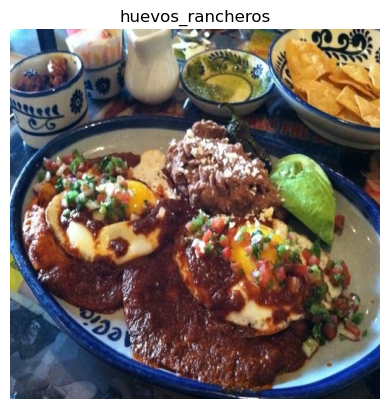

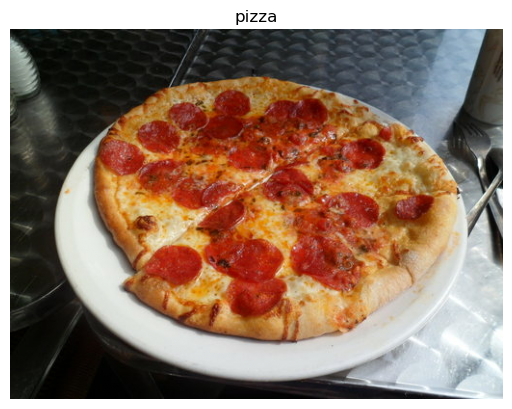

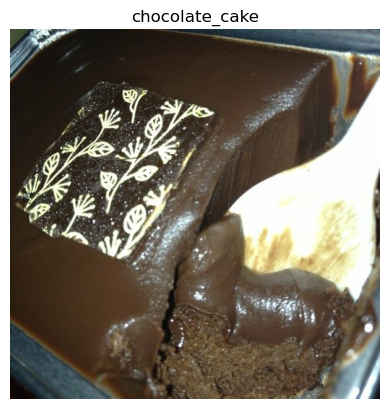

In [72]:
random_images(train_set , 3)

<h4 style="background-color:#e15b64;color:white;border-radius: 8px; padding:12px">Preprocess the dataset</h4>

In [63]:
new_dataset_train = train_set.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

In [64]:
new_dataset_train =new_dataset_train.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [65]:
new_dataset_test = test_set.map(preprocess_img , num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [66]:
new_dataset_train.element_spec , new_dataset_test.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

<h4 style="background-color:#e15b64;color:white;border-radius: 8px; padding:12px">Create Model callbacks</h4>

In [11]:
checkpoint_path = "feature_extraction_ckpt/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) 

<h4 style="background-color:#e15b64;color:white;border-radius: 8px; padding:12px">Feature Extraction with EfficientNetB0</h4>

In [32]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

In [33]:
tf.random.set_seed(42)
input_shape=(480,480,3)

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs , training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(101)(x)
outputs = tf.keras.layers.Activation("softmax",name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics =["accuracy"]
)

In [34]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 480, 480, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [35]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d_2 True float32 <Policy "float32">
dense_2 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [37]:
history_f = model.fit(new_dataset_train, 
                      epochs=3,
                      steps_per_epoch=len(new_dataset_train),
                      validation_data=new_dataset_test,
                      validation_steps=int(0.15 * len(new_dataset_test)),
                      callbacks=[create_tensorboard_callback("tensorboard", 
                                                             "model_feature_extraction"),
                                                                model_checkpoint])

In [23]:
model.evaluate(new_dataset_test)

790/790 [==============================] - 32s 41ms/step - loss: 0.9997 - accuracy: 0.7324


[0.9996928572654724, 0.7323960661888123]

In [26]:
model.save("model_feature_extraction.h5")

<h4 style="background-color:#e15b64;color:white;border-radius: 8px; padding:12px">Fine-tuning EfficientNetB0</h4>

In [11]:
load_model = tf.keras.models.load_model(path+"\saved_models\model_feature_extraction.h5")

In [12]:
load_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
for layer in load_model.layers:
    layer.trainable =True

In [14]:
load_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

<h4 style="background-color:#e15b64;color:white;border-radius: 8px; padding:12px">Callbacks for our model</h4>

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [20]:
checkpoint_path = "fine_tuned_model_checkpoints_2/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="accuracy")

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [22]:
load_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(0.0001),
                  metrics=["accuracy"])

In [47]:
history_load_model = load_model.fit(new_dataset_train,
                                   epochs=100,
                                   steps_per_epoch=len(new_dataset_train),
                                   callbacks=[
                                       create_tensorboard_callback("training_logs","model_fine_tuned_2"),
                                       model_checkpoint,
                                       early_stopping,
                                       reduce_lr
                                   ])

In [38]:
testing_model = tf.keras.models.load_model("saved_models/model_fine_tuned.h5")

In [48]:
testing_model.evaluate(new_dataset_test)

790/790 [==============================] - 35s 42ms/step - loss: 1.2792 - accuracy: 0.7693


[1.279204249382019, 0.7693069577217102]

<h4 style="background-color:#e15b64;color:white;border-radius: 8px; padding:12px">Confusion matrix and classification report</h4>

In [74]:
y_preds = testing_model.predict(new_dataset_test)

790/790 [==============================] - 32s 40ms/step


array([29, 81, 91, ..., 46, 31, 21], dtype=int64)

In [77]:
y_true=np.array([])
for image , label in new_dataset_test.unbatch():
    y_true = np.append(y_true,label.numpy())

In [78]:
y_true

array([29., 81., 91., ..., 76., 31., 21.])

In [92]:
from sklearn.metrics import confusion_matrix , accuracy_score, precision_recall_fscore_support

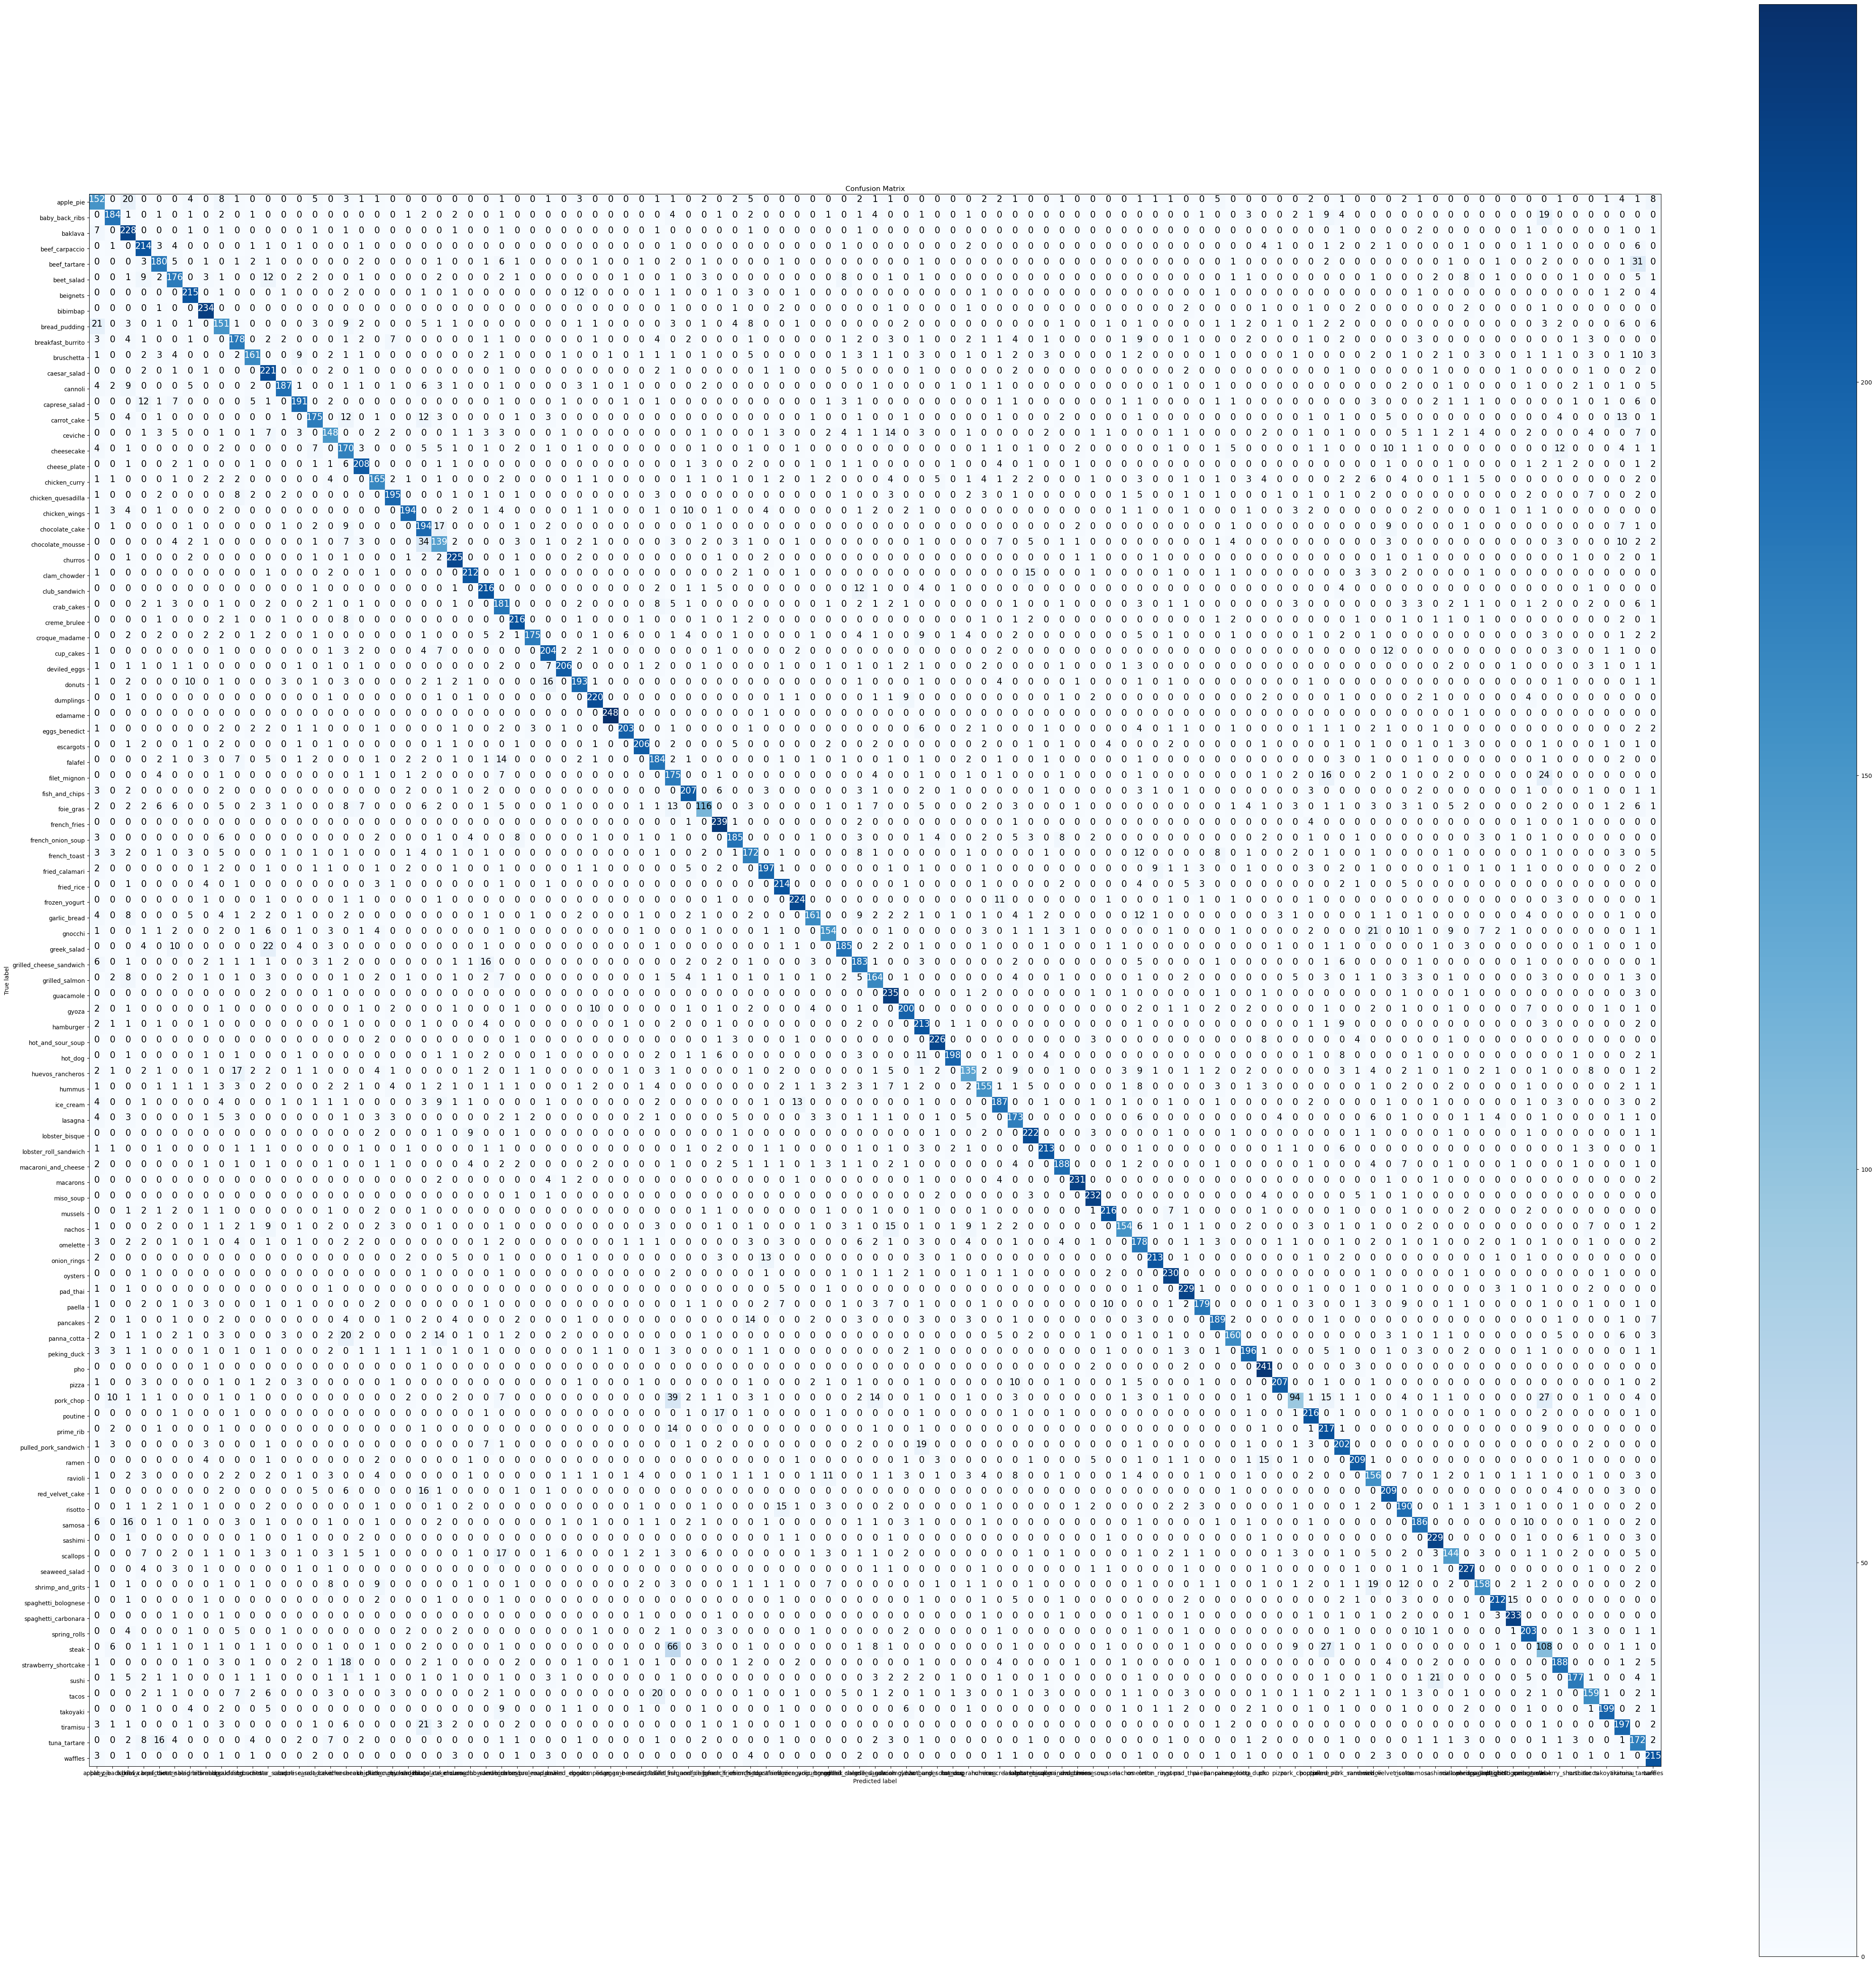

In [106]:
make_confusion_matrix(y_true,y_preds.argmax(axis=1),class_names,figsize=(60,60),savefig=True)

In [95]:
calculate_results(y_true,y_preds.argmax(axis=1))

{'accuracy': 76.93069306930693,
 'precision': 0.7788114414729321,
 'recall': 0.7693069306930693,
 'f1': 0.7690439925620225}